In [107]:
import numpy as np
import pandas as pd

SEED = 42
rng = np.random.default_rng(SEED)

In [108]:
# ============================================================
# 1) CONFIG / DADOS BASE
# ============================================================

# Fazendas
FAZENDAS = [
    "Maruim_SC",
    "Gaucha_RS",
    "CamposGerais_PR",
    "Pantanal_MS",
    "Cerrado_MT",
    "Capital_GO",
]

# Produtividade ajustada (t/ha). 0 = não plantar.
Y_ADJ = {
    "Maruim_SC": {"Aveia": 3.7, "Girassol": 0.72, "Milho": 4.2, "Soja": 2.51, "Sorgo": 1.02, "Trigo": 3.96},
    "Gaucha_RS": {"Aveia": 3.92, "Girassol": 0.0,  "Milho": 6.0, "Soja": 3.57, "Sorgo": 0.0,  "Trigo": 4.2},
    "CamposGerais_PR": {"Aveia": 5.6, "Girassol": 0.72, "Milho": 1.56, "Soja": 0.99, "Sorgo": 1.02, "Trigo": 6.0},
    "Pantanal_MS": {"Aveia": 0.0, "Girassol": 2.41, "Milho": 8.64, "Soja": 5.55, "Sorgo": 4.54, "Trigo": 0.0},
    "Cerrado_MT": {"Aveia": 1.01, "Girassol": 2.41, "Milho": 6.0, "Soja": 4.03, "Sorgo": 4.54, "Trigo": 1.08},
    "Capital_GO": {"Aveia": 1.01, "Girassol": 2.41, "Milho": 6.0, "Soja": 4.03, "Sorgo": 4.54, "Trigo": 1.08},
}

# grãos válidos por fazenda (y_adj > 0)
GRAOS_POR_FAZENDA = {f: [g for g, y in Y_ADJ[f].items() if y > 0] for f in FAZENDAS}

# Solo
SOLO = {
    "Maruim_SC":   {"N": 28, "P": 14, "K": 110, "MO": 3.2, "Na": 2, "Comp": 1.6},
    "Gaucha_RS":   {"N": 32, "P": 18, "K": 130, "MO": 3.8, "Na": 2, "Comp": 1.7},
    "CamposGerais_PR": {"N": 30, "P": 16, "K": 120, "MO": 3.5, "Na": 2, "Comp": 1.9},
    "Pantanal_MS": {"N": 24, "P": 12, "K": 105, "MO": 2.8, "Na": 4, "Comp": 1.8},
    "Cerrado_MT":  {"N": 20, "P": 10, "K": 95,  "MO": 2.3, "Na": 2, "Comp": 2.1},
    "Capital_GO":  {"N": 22, "P": 11, "K": 100, "MO": 2.5, "Na": 2, "Comp": 2.0},
}

# Manejo (parâmetros triangulares %)
MANEJO = {
    "falha_plantio_pct":   {"min": 4,  "mode": 8,  "max": 14},
    "efic_herbicida_pct":  {"min": 70, "mode": 80, "max": 90},
    "perda_colheita_pct":  {"min": 6,  "mode": 9,  "max": 15},
}

# Clima (mu/sd)
CLIMA = {
    "Maruim_SC":   {"chuva_mu": 900, "chuva_sd": 180, "temp_mu": 20.0, "temp_sd": 1.5, "rad_mu": 15.0, "rad_sd": 1.8},
    "Gaucha_RS":   {"chuva_mu": 850, "chuva_sd": 160, "temp_mu": 19.0, "temp_sd": 1.8, "rad_mu": 15.5, "rad_sd": 2.0},
    "CamposGerais_PR": {"chuva_mu": 950, "chuva_sd": 200, "temp_mu": 18.5, "temp_sd": 2.0, "rad_mu": 14.8, "rad_sd": 1.6},
    "Pantanal_MS": {"chuva_mu": 780, "chuva_sd": 170, "temp_mu": 23.5, "temp_sd": 1.5, "rad_mu": 17.0, "rad_sd": 2.2},
    "Cerrado_MT":  {"chuva_mu": 820, "chuva_sd": 220, "temp_mu": 25.0, "temp_sd": 1.8, "rad_mu": 18.5, "rad_sd": 2.5},
    "Capital_GO":  {"chuva_mu": 860, "chuva_sd": 210, "temp_mu": 24.5, "temp_sd": 1.6, "rad_mu": 18.0, "rad_sd": 2.1},
}

# Regimes climáticos anuais
REGIMES = {
    "ruim":   {"prob": 0.20, "chuva": -0.12, "temp": +0.6, "rad": -0.08},
    "normal": {"prob": 0.60, "chuva":  0.00, "temp": 0.0, "rad":  0.00},
    "bom":    {"prob": 0.20, "chuva": +0.12, "temp": -0.6, "rad": +0.08},
}

# Sensibilidades por cultura
SENS_CULTURA = {
    "Milho":     {"chuva": 1.10, "temp": 1.05, "rad": 1.00},
    "Soja":      {"chuva": 1.00, "temp": 1.00, "rad": 1.00},
    "Sorgo":     {"chuva": 0.90, "temp": 1.00, "rad": 1.05},
    "Trigo":     {"chuva": 0.95, "temp": 1.10, "rad": 1.00},
    "Aveia":     {"chuva": 0.95, "temp": 1.10, "rad": 1.00},
    "Girassol":  {"chuva": 0.80, "temp": 1.00, "rad": 1.10},
}

In [109]:
# ============================================================
# 2) SAMPLERS / DISTRIBUIÇÕES
# ============================================================

def sample_triangular(param, size=None, rng=rng):
    """Triangular: min, mode, max."""
    return rng.triangular(param["min"], param["mode"], param["max"], size=size)

def sample_normal_trunc(mu, sd, low, high, size=None, rng=rng):
    """
    Normal truncada via rejeição simples.
    Garante valores dentro de [low, high].
    """
    x = rng.normal(mu, sd, size=size)
    if size is None:
        while (x < low) or (x > high):
            x = rng.normal(mu, sd)
        return x

    mask = (x < low) | (x > high)
    while mask.any():
        x[mask] = rng.normal(mu, sd, size=mask.sum())
        mask = (x < low) | (x > high)
    return x

In [110]:
# ============================================================
# 3) CLIMA
# ============================================================

def sample_clima(fazenda, rng=rng):
    """Amostra única de clima anual com SD ampliado."""
    p = CLIMA[fazenda]

    chuva_sd = p["chuva_sd"] * 1.5
    temp_sd  = p["temp_sd"]  * 1.4
    rad_sd   = p["rad_sd"]   * 1.5

    chuva = sample_normal_trunc(p["chuva_mu"], chuva_sd, 300, 1800, rng=rng)
    temp  = sample_normal_trunc(p["temp_mu"],  temp_sd,  12,  32,   rng=rng)
    rad   = sample_normal_trunc(p["rad_mu"],   rad_sd,   10,  25,   rng=rng)

    return {"chuva_mm": chuva, "temp_c": temp, "rad_mj": rad}


def sample_clima_vec(fazenda, size, rng=rng):
    """Amostras vetorizadas (Monte Carlo) com SD ampliado."""
    p = CLIMA[fazenda]

    chuva_sd = p["chuva_sd"] * 1.5
    temp_sd  = p["temp_sd"]  * 1.4
    rad_sd   = p["rad_sd"]   * 1.5

    chuva = sample_normal_trunc(p["chuva_mu"], chuva_sd, 300, 1800, size=size, rng=rng)
    temp  = sample_normal_trunc(p["temp_mu"],  temp_sd,  12,  32,   size=size, rng=rng)
    rad   = sample_normal_trunc(p["rad_mu"],   rad_sd,   10,  25,   size=size, rng=rng)

    return {"chuva_mm": chuva, "temp_c": temp, "rad_mj": rad}

In [111]:
# ============================================================
# 4) ÍNDICES DE PRODUÇÃO
# ============================================================

def clima_factor(value, ideal, span):
    """
    Resposta parabólica:
    ideal = centro ótimo
    span  = tolerância (quanto maior, mais suave).
    Clip em [0.6, 1.2].
    """
    f = 1 - ((value - ideal) / span)**2
    return np.clip(f, 0.6, 1.2)

def indice_clima(fazenda, clima):
    """Índice climático (vetorial ou escalar)."""
    chuva = clima["chuva_mm"]
    temp  = clima["temp_c"]
    rad   = clima["rad_mj"]

    f_chuva = clima_factor(chuva, ideal=900, span=500)
    f_temp  = clima_factor(temp,  ideal=24,  span=6)
    f_rad   = clima_factor(rad,   ideal=17,  span=5)

    I = (0.4*f_chuva + 0.4*f_temp + 0.2*f_rad)
    return I

def indice_manejo(rng=rng):
    """Índice de manejo escalar"""
    falha = sample_triangular(MANEJO["falha_plantio_pct"], rng=rng) / 100
    herb  = sample_triangular(MANEJO["efic_herbicida_pct"], rng=rng) / 100
    perda = sample_triangular(MANEJO["perda_colheita_pct"], rng=rng) / 100

    competicao = 1 - (1 - herb)*0.5
    bruto = (1 - falha) * competicao * (1 - perda)

    return np.clip(bruto, 0.7, 1.1)

def indice_manejo_vec(size, rng=rng):
    """VERSÃO VETORIZADA"""
    falha = sample_triangular(MANEJO["falha_plantio_pct"], size=size, rng=rng) / 100
    herb  = sample_triangular(MANEJO["efic_herbicida_pct"], size=size, rng=rng) / 100
    perda = sample_triangular(MANEJO["perda_colheita_pct"], size=size, rng=rng) / 100

    competicao = 1 - (1 - herb)*0.5
    bruto = (1 - falha) * competicao * (1 - perda)

    return np.clip(bruto, 0.7, 1.1)

def indice_fertilidade(fazenda):
    """Índice de fertilidade fixo por fazenda."""
    s = SOLO[fazenda]

    fN  = clima_factor(s["N"],  ideal=30,  span=15)
    fP  = clima_factor(s["P"],  ideal=16,  span=10)
    fK  = clima_factor(s["K"],  ideal=110, span=40)
    fMO = clima_factor(s["MO"], ideal=3.2, span=2.0)

    fNa   = clima_factor(s["Na"],   ideal=0,   span=5)
    fComp = clima_factor(s["Comp"], ideal=1.4, span=1.0)

    fNa_pen   = 1 - (fNa - 1) * 0.4
    fComp_pen = 1 - (fComp - 1) * 0.4

    I = (
        fN*0.25 +
        fP*0.25 +
        fK*0.20 +
        fMO*0.15 +
        fNa_pen*0.07 +
        fComp_pen*0.08
    )

    return np.clip(I, 0.7, 1.2)

In [112]:
# ============================================================
# 5) PARÂMETROS DO MONTE CARLO
# ============================================================

N_ITERS = 1_000_000
N_ANOS  = 4
ANOS    = [f"Ano_{i+1}" for i in range(N_ANOS)]

regimes_list = list(REGIMES.keys())
regime_probs = [REGIMES[r]["prob"] for r in regimes_list]

In [113]:
# ============================================================
# 6) MOTOR MONTE CARLO (com saída de clima/chuva)
# ============================================================

def simular_monte_carlo(
    fazendas=FAZENDAS,
    anos=ANOS,
    n_iters=N_ITERS,
    rng=rng
):
    resultados = []
    clima_rows = []      # ✅ novo: guarda chuva por ano/fazenda
    shock_prev = 1.0     # autocorrelação inicial

    for fazenda in fazendas:
        graos = GRAOS_POR_FAZENDA[fazenda]
        I_fert = indice_fertilidade(fazenda)

        for ano in anos:

            # 1) regime anual
            regime = rng.choice(regimes_list, p=regime_probs)
            reg = REGIMES[regime]

            # 2) choque anual autocorrelacionado
            shock_ano = 0.6 * shock_prev + 0.4 * rng.normal(1.0, 0.04)
            shock_prev = shock_ano
            shock_ano = np.clip(shock_ano, 0.85, 1.15)

            # 3) clima base vetorizado (Bloco 3 já com SD aumentado)
            clima = sample_clima_vec(fazenda, n_iters, rng=rng)
            clima["chuva_mm"] *= (1 + reg["chuva"]) * shock_ano
            clima["temp_c"]   += reg["temp"] * shock_ano
            clima["rad_mj"]   *= (1 + reg["rad"]) * shock_ano

            # ✅ salvar estatísticas de chuva desse ano/fazenda
            chuva_vec = clima["chuva_mm"]
            c_p10, c_p50, c_p90 = np.percentile(chuva_vec, [10, 50, 90])

            clima_rows.append({
                "Fazenda": fazenda,
                "Ano": ano,
                "Regime_Climatico": regime,
                "Choque_Anual": float(shock_ano),
                "Chuva_media_mm": float(np.mean(chuva_vec)),
                "Chuva_p10_mm": float(c_p10),
                "Chuva_p50_mm": float(c_p50),
                "Chuva_p90_mm": float(c_p90),
            })

            # 4) índice climático base (sem normalização)
            I_clim = indice_clima(fazenda, clima)
            I_clim = np.clip(I_clim, 0.50, 1.40)

            # 5) índice manejo base (sem normalização)
            I_man = indice_manejo_vec(n_iters, rng=rng)
            I_man = np.clip(I_man, 0.60, 1.35)

            man_shock = rng.normal(1.0, 0.03)
            I_man = np.clip(I_man * man_shock, 0.60, 1.40)

            # 6) culturas
            for grao in graos:
                sens = SENS_CULTURA[grao]

                I_clim_grao = I_clim * sens["chuva"] * sens["temp"] * sens["rad"]
                I_clim_grao = np.clip(I_clim_grao, 0.55, 1.35)

                y_base = Y_ADJ[fazenda][grao]
                y_sim  = y_base * I_clim_grao * I_man * I_fert

                media  = float(np.mean(y_sim))
                desvio = float(np.std(y_sim, ddof=1))
                risco  = float(desvio / media) if media > 0 else np.nan

                p10, p50, p90 = np.percentile(y_sim, [10, 50, 90])

                resultados.append({
                    "Fazenda": fazenda,
                    "Grao": grao,
                    "Ano": ano,
                    "Media_t_ha": media,
                    "Desvio_t_ha": desvio,
                    "Risco_CV": risco,
                    "P10_t_ha": float(p10),
                    "P50_t_ha": float(p50),
                    "P90_t_ha": float(p90),
                    "Regime_Climatico": regime,
                    "Choque_Anual": float(shock_ano),
                })

    df_prod  = pd.DataFrame(resultados)
    df_clima = pd.DataFrame(clima_rows)
    return df_prod, df_clima


# rodar simulação
df_resultados, df_clima = simular_monte_carlo()

# opcional: arredondar
df_final = df_resultados.copy()
for col in ["Media_t_ha","Desvio_t_ha","Risco_CV","P10_t_ha","P50_t_ha","P90_t_ha"]:
    df_final[col] = df_final[col].round(3)

df_clima.head()

,Fazenda,Ano,Regime_Climatico,Choque_Anual,Chuva_media_mm,Chuva_p10_mm,Chuva_p50_mm,Chuva_p90_mm
0,Maruim_SC,Ano_1,normal,0.983360,893.749237,561.954751,889.093422,1226.699854
1,Maruim_SC,Ano_2,ruim,0.999233,799.007006,502.402580,794.776642,1096.546144
2,Maruim_SC,Ano_3,normal,1.020633,927.531995,583.233130,922.572756,1273.348696
3,Maruim_SC,Ano_4,normal,0.988959,898.879764,565.160997,894.429674,1233.557035
4,Gaucha_RS,Ano_1,normal,0.985615,844.429946,547.040484,840.549247,1142.667337


In [114]:
# ============================================================
# 7) RESUMO 4 ANOS
# ============================================================

df_4anos = (
    df_resultados
    .groupby(["Fazenda", "Grao"], as_index=False)
    .agg(
        Media_4anos=("Media_t_ha", "mean"),
        Desvio_4anos=("Desvio_t_ha", "mean"),
        Risco_4anos=("Risco_CV", "mean")
    )
)

df_4anos["Media_4anos"]  = df_4anos["Media_4anos"].round(3)
df_4anos["Desvio_4anos"] = df_4anos["Desvio_4anos"].round(3)
df_4anos["Risco_4anos"]  = df_4anos["Risco_4anos"].round(3)

df_4anos

,Fazenda,Grao,Media_4anos,Desvio_4anos,Risco_4anos
0,CamposGerais_PR,Aveia,3.176,0.387,0.122
1,CamposGerais_PR,Girassol,0.345,0.040,0.117
2,CamposGerais_PR,Milho,0.978,0.119,0.122
3,CamposGerais_PR,Soja,0.537,0.065,0.122
4,CamposGerais_PR,Sorgo,0.523,0.064,0.122
5,CamposGerais_PR,Trigo,3.403,0.414,0.122
6,Capital_GO,Aveia,0.553,0.063,0.114
7,Capital_GO,Girassol,1.112,0.126,0.113
8,Capital_GO,Milho,3.633,0.414,0.114
9,Capital_GO,Soja,2.113,0.241,0.114


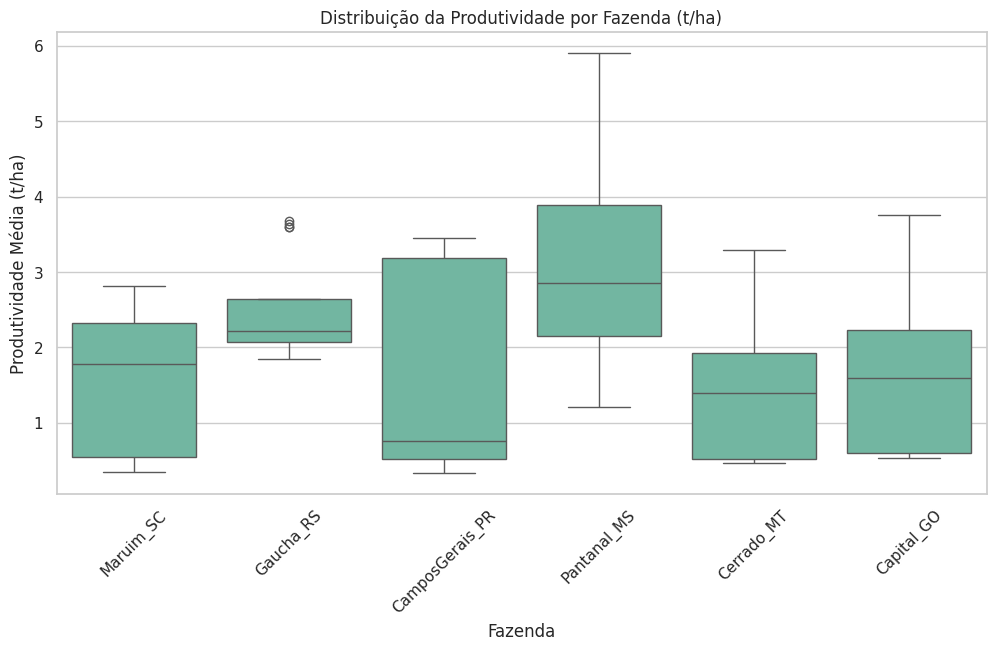

In [115]:
# ============================================================
# 8) PLOTS GERAIS
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="Set2")

plt.figure(figsize=(12,6))
sns.boxplot(data=df_resultados, x="Fazenda", y="Media_t_ha")
plt.title("Distribuição da Produtividade por Fazenda (t/ha)")
plt.xticks(rotation=45)
plt.ylabel("Produtividade Média (t/ha)")
plt.show()

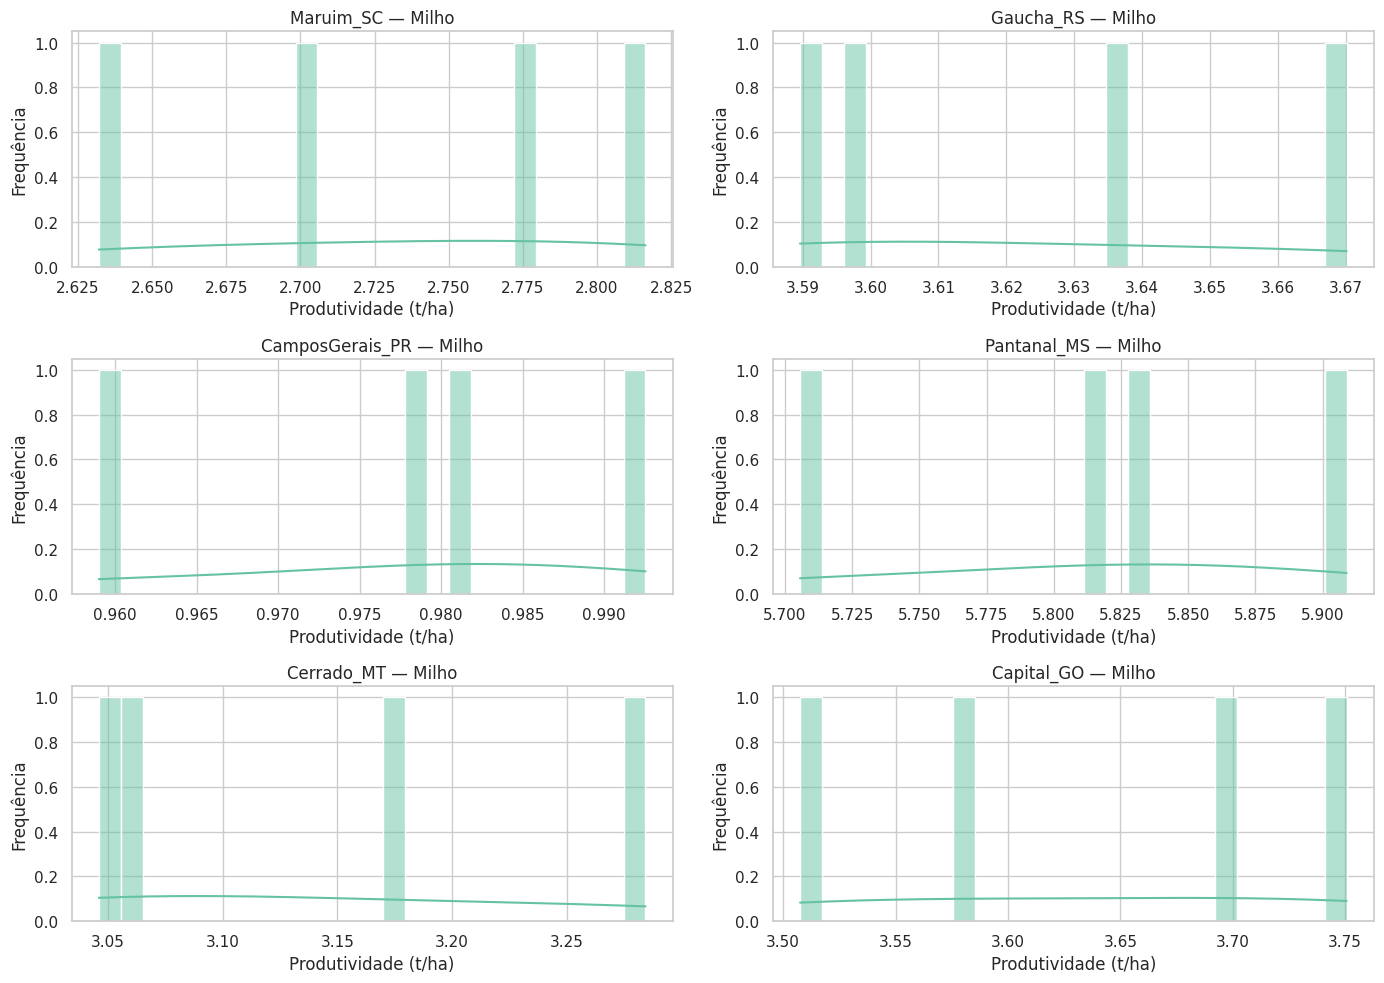

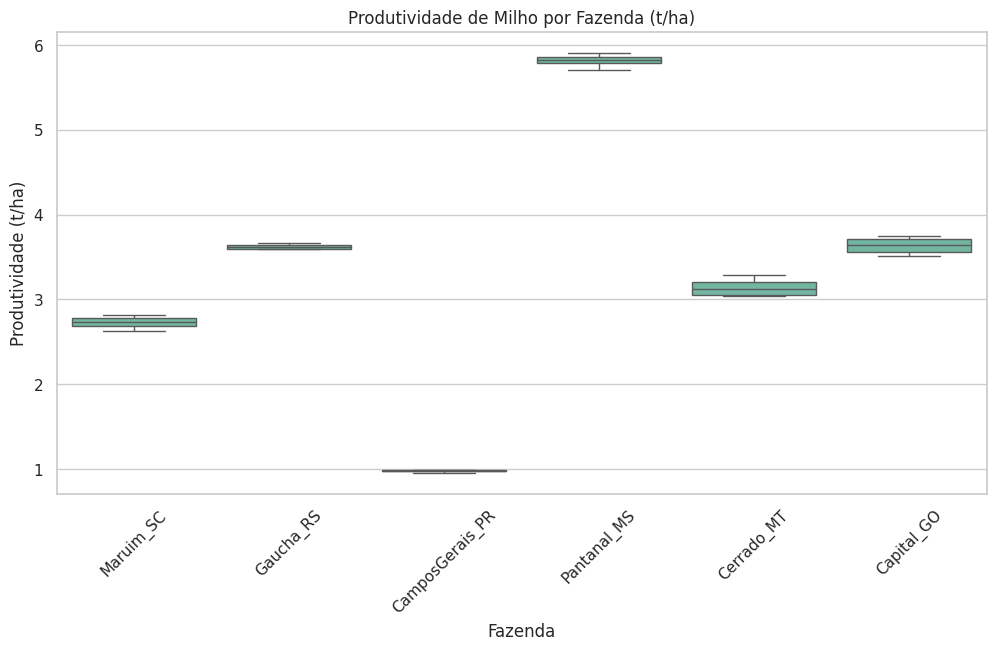

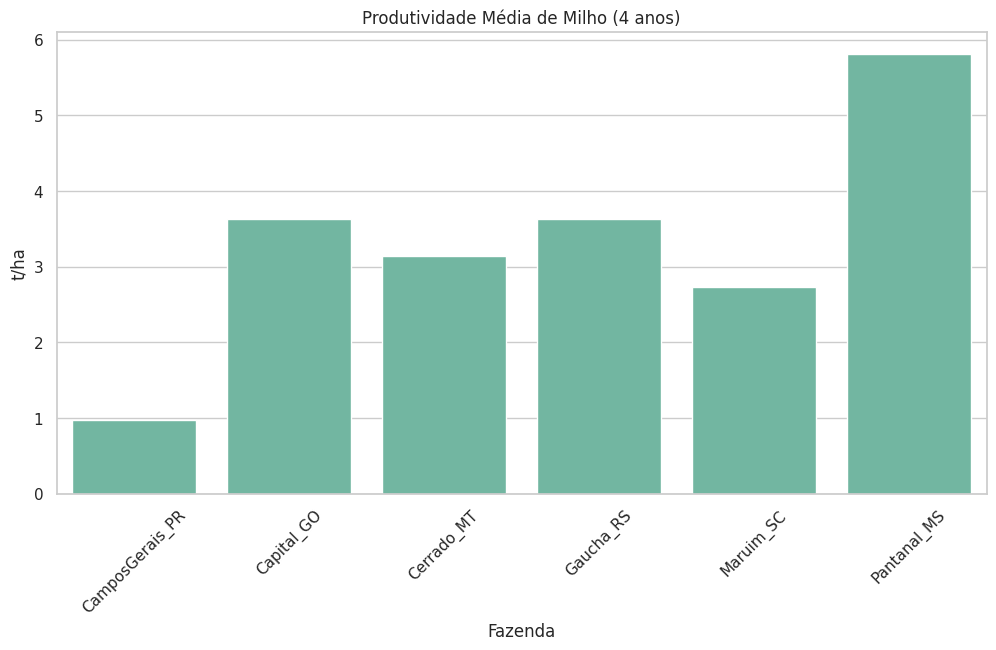

In [116]:
# ============================================================
# 9) PLOTS MILHO
# ============================================================

df_milho = df_resultados[df_resultados["Grao"] == "Milho"]
fazendas_milho = df_milho["Fazenda"].unique()

# ---- histogramas por fazenda
plt.figure(figsize=(14,10))
for i, fazenda in enumerate(fazendas_milho, 1):
    plt.subplot(3, 2, i)
    dados = df_milho[df_milho["Fazenda"] == fazenda]["Media_t_ha"]
    sns.histplot(dados, kde=True, bins=25)
    plt.title(f"{fazenda} — Milho")
    plt.xlabel("Produtividade (t/ha)")
    plt.ylabel("Frequência")

plt.tight_layout()
plt.show()

# ---- boxplot milho
plt.figure(figsize=(12,6))
sns.boxplot(data=df_milho, x="Fazenda", y="Media_t_ha")
plt.title("Produtividade de Milho por Fazenda (t/ha)")
plt.xticks(rotation=45)
plt.ylabel("Produtividade (t/ha)")
plt.show()

# ---- média 4 anos milho
df_milho_4anos = (
    df_milho.groupby("Fazenda", as_index=False)
            .agg(Media_4anos=("Media_t_ha", "mean"))
)

plt.figure(figsize=(12,6))
sns.barplot(data=df_milho_4anos, x="Fazenda", y="Media_4anos")
plt.title("Produtividade Média de Milho (4 anos)")
plt.xticks(rotation=45)
plt.ylabel("t/ha")
plt.show()

In [117]:
# ============================================================
# 10) RELATÓRIO FINAL
# ============================================================

def imprimir_relatorio(df, fazendas=FAZENDAS, anos=ANOS):
    print("\n" + "="*80)
    print("  RELATÓRIO FINAL DE PRODUTIVIDADE — SIMULAÇÃO MONTE CARLO (4 ANOS)")
    print("="*80 + "\n")

    for fazenda in fazendas:
        df_faz = df[df["Fazenda"] == fazenda]
        print(f"FAZENDA: {fazenda}")
        print("-"*80)

        for grao in df_faz["Grao"].unique():
            df_g = df_faz[df_faz["Grao"] == grao]
            print(f"  Grão: {grao}")

            for ano in anos:
                row = df_g[df_g["Ano"] == ano].iloc[0]
                print(
                    f"    {ano}: "
                    f"Prod. esperada = {row['Media_t_ha']:.3f} t/ha | "
                    f"Desvio = {row['Desvio_t_ha']:.3f} | "
                    f"Risco (CV) = {row['Risco_CV']:.3f}"
                )
            print("")

        print("="*80 + "\n")

imprimir_relatorio(df_resultados)


  RELATÓRIO FINAL DE PRODUTIVIDADE — SIMULAÇÃO MONTE CARLO (4 ANOS)

FAZENDA: Maruim_SC
--------------------------------------------------------------------------------
  Grão: Aveia
    Ano_1: Prod. esperada = 2.211 t/ha | Desvio = 0.269 | Risco (CV) = 0.122
    Ano_2: Prod. esperada = 2.245 t/ha | Desvio = 0.278 | Risco (CV) = 0.124
    Ano_3: Prod. esperada = 2.155 t/ha | Desvio = 0.264 | Risco (CV) = 0.122
    Ano_4: Prod. esperada = 2.098 t/ha | Desvio = 0.256 | Risco (CV) = 0.122

  Grão: Girassol
    Ano_1: Prod. esperada = 0.363 t/ha | Desvio = 0.043 | Risco (CV) = 0.119
    Ano_2: Prod. esperada = 0.369 t/ha | Desvio = 0.044 | Risco (CV) = 0.121
    Ano_3: Prod. esperada = 0.354 t/ha | Desvio = 0.042 | Risco (CV) = 0.119
    Ano_4: Prod. esperada = 0.344 t/ha | Desvio = 0.041 | Risco (CV) = 0.119

  Grão: Milho
    Ano_1: Prod. esperada = 2.774 t/ha | Desvio = 0.338 | Risco (CV) = 0.122
    Ano_2: Prod. esperada = 2.816 t/ha | Desvio = 0.349 | Risco (CV) = 0.124
    Ano_3: Pr

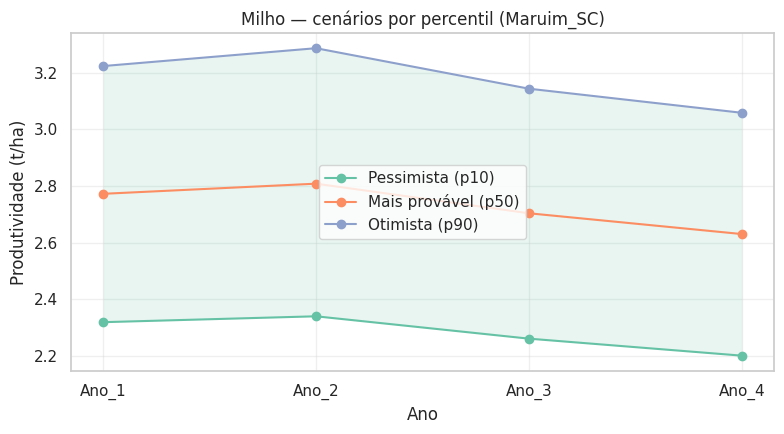

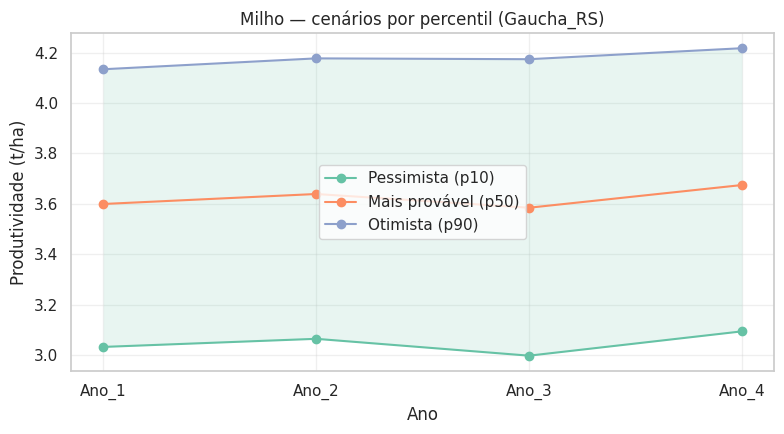

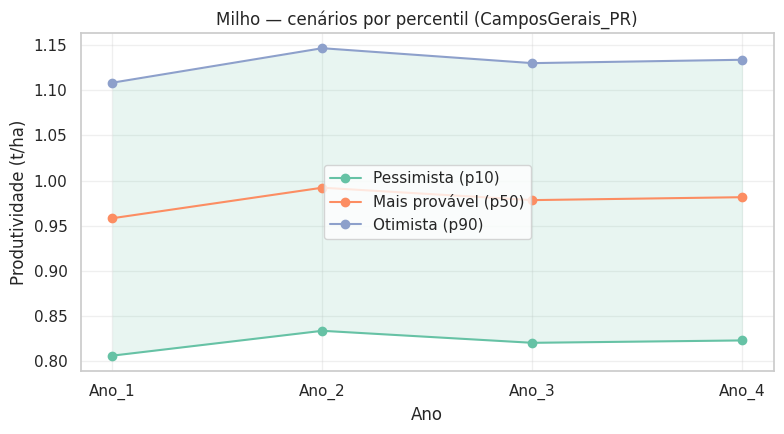

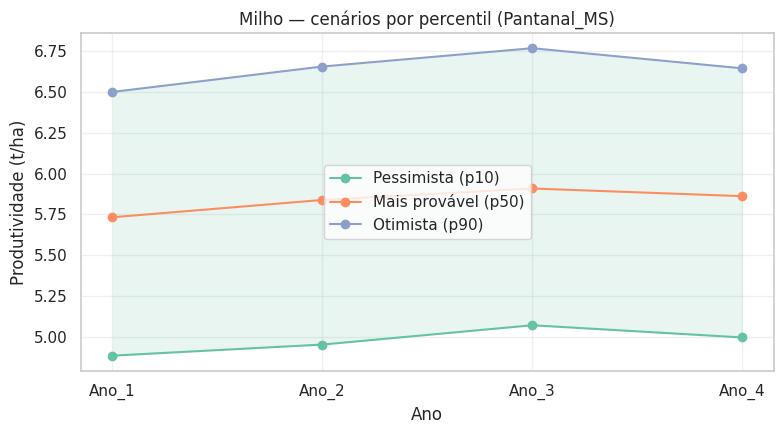

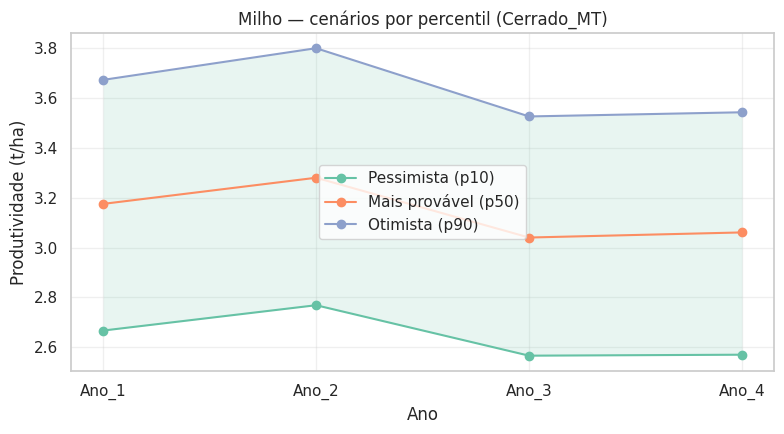

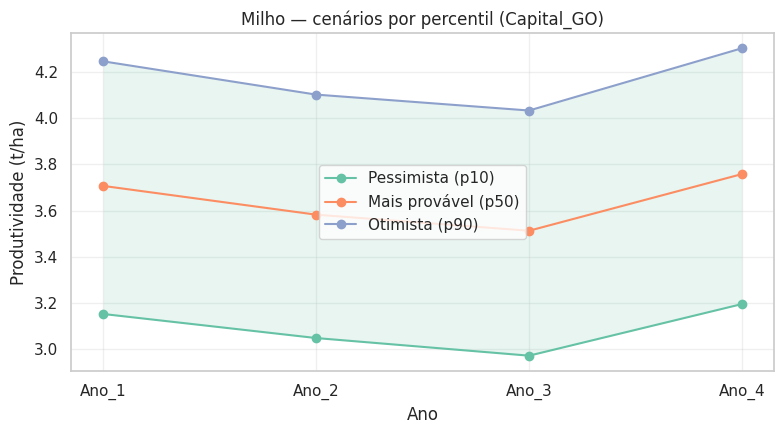

In [118]:
# ============================================================
# 12) GRÁFICO 3 CENÁRIOS (P10/P50/P90) — MILHO por fazenda
# ============================================================
import matplotlib.pyplot as plt
import numpy as np

def plot_cenarios_milho_percentil(df_resultados):
    df_milho = df_resultados[df_resultados["Grao"] == "Milho"].copy()
    anos_ordem = sorted(df_milho["Ano"].unique(), key=lambda x: int(x.split("_")[1]))

    for fazenda in df_milho["Fazenda"].unique():
        d = (
            df_milho[df_milho["Fazenda"] == fazenda]
            .set_index("Ano")
            .loc[anos_ordem]
            .reset_index()
        )

        pess = d["P10_t_ha"].values
        prov = d["P50_t_ha"].values
        otim = d["P90_t_ha"].values

        x = np.arange(len(anos_ordem))

        plt.figure(figsize=(8,4.5))
        plt.plot(x, pess, marker="o", label="Pessimista (p10)")
        plt.plot(x, prov, marker="o", label="Mais provável (p50)")
        plt.plot(x, otim, marker="o", label="Otimista (p90)")
        plt.fill_between(x, pess, otim, alpha=0.15)

        plt.title(f"Milho — cenários por percentil ({fazenda})")
        plt.xticks(x, anos_ordem)
        plt.ylabel("Produtividade (t/ha)")
        plt.xlabel("Ano")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_cenarios_milho_percentil(df_resultados)


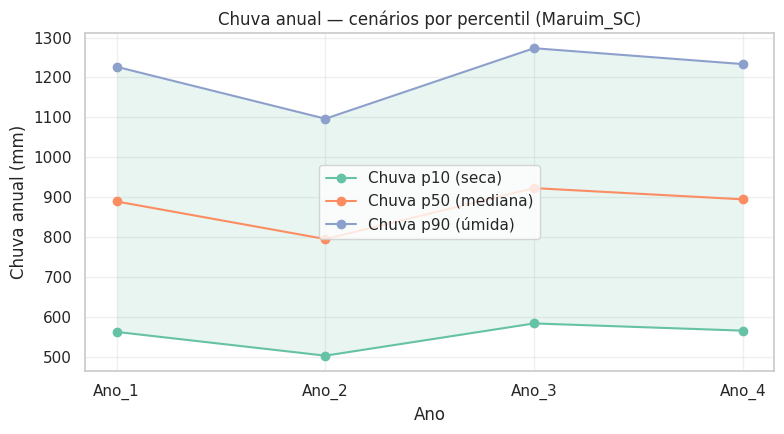

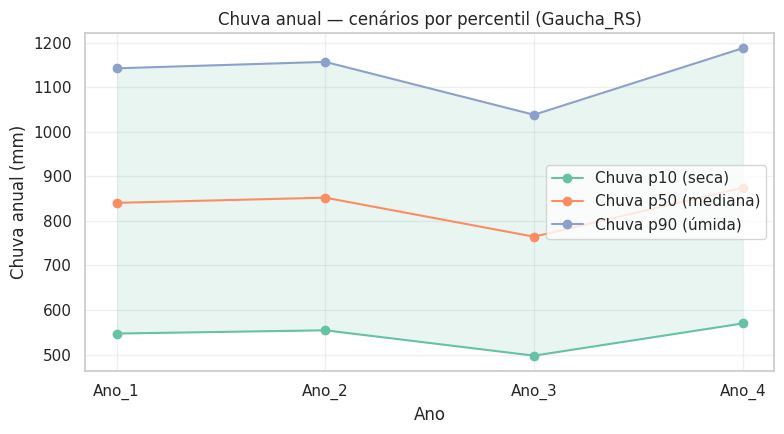

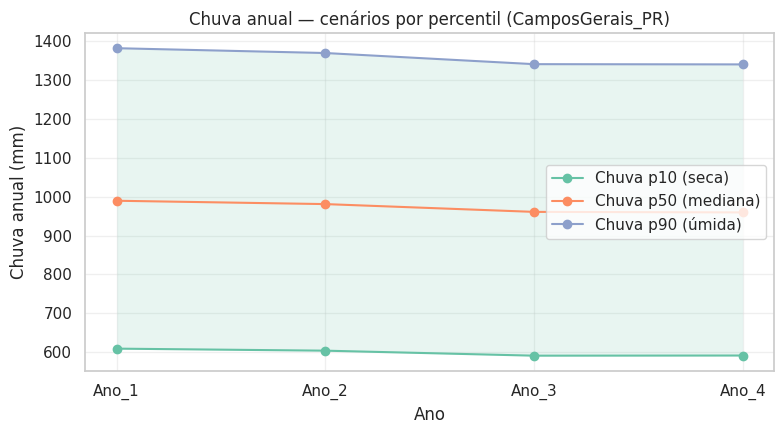

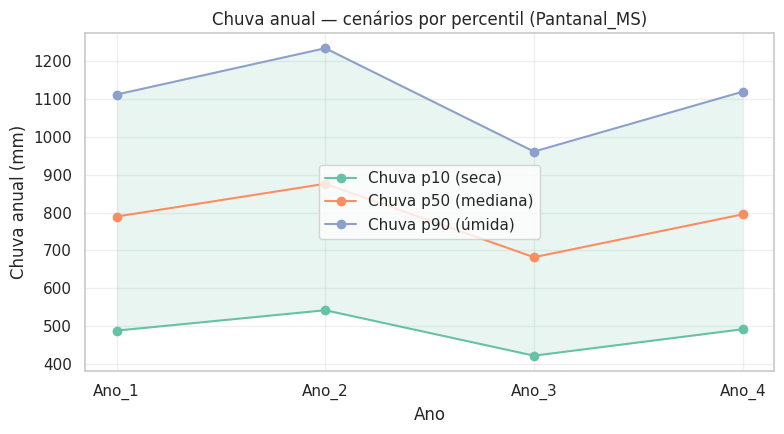

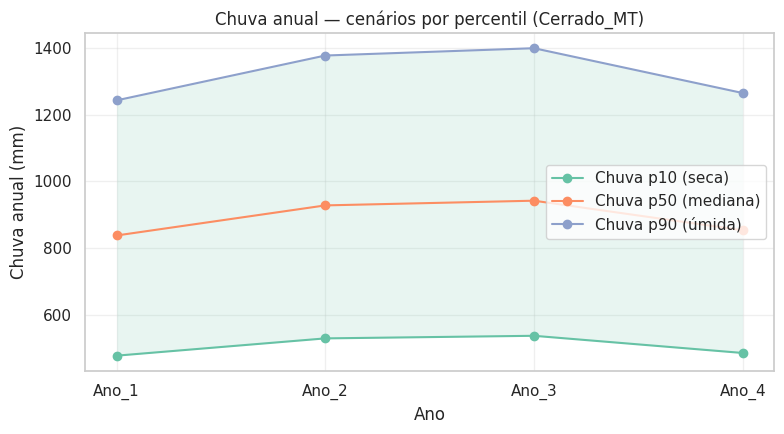

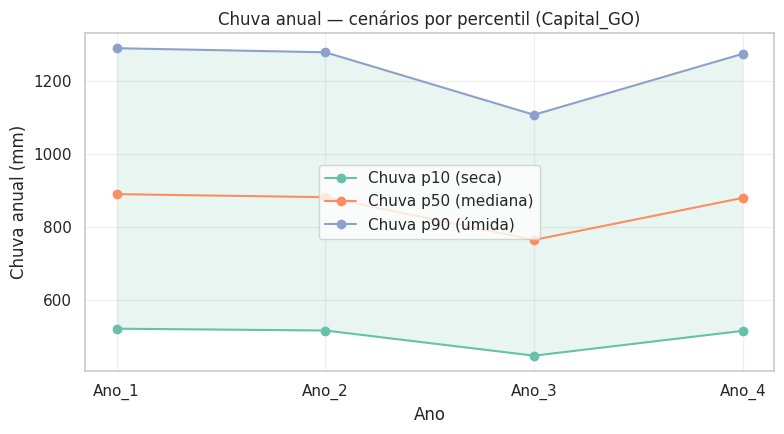

In [119]:
# ============================================================
# 13) GRÁFICO CHUVA POR ANO — por fazenda
# ============================================================
import matplotlib.pyplot as plt
import numpy as np

def plot_chuva_por_fazenda(df_clima):
    anos_ordem = sorted(df_clima["Ano"].unique(), key=lambda x: int(x.split("_")[1]))
    x = np.arange(len(anos_ordem))

    for fazenda in df_clima["Fazenda"].unique():
        d = (
            df_clima[df_clima["Fazenda"] == fazenda]
            .set_index("Ano")
            .loc[anos_ordem]
            .reset_index()
        )

        p10 = d["Chuva_p10_mm"].values
        p50 = d["Chuva_p50_mm"].values
        p90 = d["Chuva_p90_mm"].values

        plt.figure(figsize=(8,4.5))
        plt.plot(x, p10, marker="o", label="Chuva p10 (seca)")
        plt.plot(x, p50, marker="o", label="Chuva p50 (mediana)")
        plt.plot(x, p90, marker="o", label="Chuva p90 (úmida)")
        plt.fill_between(x, p10, p90, alpha=0.15)

        plt.title(f"Chuva anual — cenários por percentil ({fazenda})")
        plt.xticks(x, anos_ordem)
        plt.ylabel("Chuva anual (mm)")
        plt.xlabel("Ano")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_chuva_por_fazenda(df_clima)